In [2]:
from pyknp import KNP
knp = KNP()

def knp_deps(sent):
    result = knp.parse(sent)

    for bnst in result.bnst_list():
        parent = bnst.parent
        if parent is not None:
            child_rep = " ".join(mrph.repname for mrph in bnst.mrph_list())
            parent_rep = " ".join(mrph.repname for mrph in parent.mrph_list())
            print(child_rep, "->", parent_rep)

knp_deps("望遠鏡で泳いでいる少女を見た。")

望遠/ぼうえん 鏡/きょう  -> 見る/みる 
泳ぐ/およぐ いる/いる -> 少女/しょうじょ 
少女/しょうじょ  -> 見る/みる 


In [33]:
sent="望遠鏡で泳いでいる少女を見た。"
result = knp.parse(sent)
for bnst in result.bnst_list():
    print(f"{bnst.bnst_id}, {bnst.midasi}, {bnst.parent_id}, {bnst.repname}, {bnst.dpndtype}")

0, 望遠鏡で, 3, 望遠/ぼうえん+鏡/きょう?鏡/かがみ, D
1, 泳いでいる, 2, 泳ぐ/およぐ, D
2, 少女を, 3, 少女/しょうじょ, D
3, 見た。, -1, 見る/みる, D


In [34]:
result.draw_bnst_tree()

望遠n鏡nでp──┐
 泳いでvいるs┐│
       少女nをp┤
         見たv。*
 

In [35]:
result.draw_tag_tree()

   望遠n┐　　　
    鏡nでp──┐
泳いでvいるs┐│
      少女nをp┤
        見たv。*
 

In [105]:
upos_maps={'形容詞':'ADJ', 'p':'ADP', 'd':'ADV',
           'u':'AUX', 'c':'CCONJ', 'h':'DET',
           'e':'INTJ', '名詞':'NOUN', 'm':'NUM',
           'z':'PART', 'r':'PRON', 'nh':'PROPN',
           'wp':'PUNCT', 'ws':'SYM',
           '動詞':'VERB', 'x':'X'
          }
POS_MARK = {
    '特殊': '*',
    '動詞': 'v',
    '形容詞': 'j',
    '判定詞': 'c',
    '助動詞': 'x',
    '名詞': 'n',
    '固有名詞': 'N',
    '人名': 'J',
    '地名': 'C',
    '組織名': 'A',
    '指示詞': 'd',
    '副詞': 'a',
    '助詞': 'p',
    '接続詞': 'c',
    '連体詞': 'm',
    '感動詞': '!',
    '接頭辞': 'p',
    '接尾辞': 's',
    '未定義語': '?'
}
ner_mappings={'固有名詞':'MISC',
              '人名':'PERSON', '地名':'LOC',
              '組織名':'ORG'}
def pos_list(leaf):
    import re
    string=[]
    for mrph in leaf.mrph_list():
        # string += mrph.midasi
        # bunrui (str): 品詞細分類
        # hinsi (str): 品詞
        if re.search("^(?:固有名詞|人名|地名)$", mrph.bunrui):
            string.append(POS_MARK[mrph.bunrui])
        else:
            string.append(POS_MARK[mrph.hinsi])
    return string
def entity_list(leaf):
    import re
    string=[]
    for mrph in leaf.mrph_list():
        if mrph.bunrui in ner_mappings:
            string.append(ner_mappings[mrph.bunrui])
    return string

In [106]:
import sagas

def parse_knp(sents, verbose=False):
    result = knp.parse(sents)
    print("文節")
    rs=[]
    for bnst in result.bnst_list(): # 各文節へのアクセス
        if verbose:
            print("\tID:%d, 見出し:%s, 係り受けタイプ:%s, 親文節ID:%d, 素性:%s" \
                    % (bnst.bnst_id, "".join(mrph.midasi for mrph in bnst.mrph_list()), bnst.dpndtype, bnst.parent_id, bnst.fstring))
        rs.append((bnst.bnst_id, "".join(mrph.midasi for mrph in bnst.mrph_list()), bnst.dpndtype, bnst.parent_id, bnst.fstring))
    display(sagas.to_df(rs, ['ID', '見出し', '係り受けタイプ(dep_type)', '親文節ID', '素性']))    

    print("基本句")
    rs=[]
    for tag in result.tag_list(): # 各基本句へのアクセス
        if verbose:
            print("\tID:%d, 見出し:%s, 係り受けタイプ:%s, 親基本句ID:%d, 素性:%s" \
                    % (tag.tag_id, "".join(mrph.midasi for mrph in tag.mrph_list()), tag.dpndtype, tag.parent_id, tag.fstring))
        rs.append((tag.tag_id, "".join(mrph.midasi for mrph in tag.mrph_list()), 
                   ",".join(pos_list(tag)),
                   ",".join(entity_list(tag)),
                   tag.dpndtype, tag.parent_id, tag.fstring))
    display(sagas.to_df(rs, ['ID', '見出し', 'POS', 'Entities',
                             '係り受けタイプ', '親基本句ID', '素性']))

    print("形態素")
    rs=[]
    for mrph in result.mrph_list(): # 各形態素へのアクセス
        if verbose:
            print("\tID:%d, 見出し:%s, 読み:%s, 原形:%s, 品詞:%s, 品詞細分類:%s, 活用型:%s, 活用形:%s, 意味情報:%s, 代表表記:%s" \
                    % (mrph.mrph_id, mrph.midasi, mrph.yomi, mrph.genkei, mrph.hinsi, mrph.bunrui, mrph.katuyou1, mrph.katuyou2, mrph.imis, mrph.repname))
        rs.append((mrph.mrph_id, mrph.midasi, mrph.yomi, mrph.genkei, mrph.hinsi, mrph.bunrui, mrph.katuyou1, mrph.katuyou2, mrph.imis, mrph.repname))
    display(sagas.to_df(rs, 'ID:%d, 見出し:%s, 読み:%s, 原形:%s, 品詞:%s, 品詞細分類:%s, 活用型:%s, 活用形:%s, 意味情報:%s, 代表表記:%s'.split(', ')))

parse_knp("下鴨神社の参道は暗かった。")

文節


,ID,見出し,係り受けタイプ(dep_type),親文節ID,素性
0,0,下鴨神社の,D,1,<文頭><地名><助詞><連体修飾><体言><係:ノ格><区切:0-4><準主題表現><正規...
1,1,参道は,D,2,<ハ><助詞><体言><係:未格><提題><区切:3-5><主題表現><格要素><連用要素>...
2,2,暗かった。,D,-1,<文末><時制-過去><句点><用言:形><レベル:C><区切:5-5><ID:（文末）><...


基本句


,ID,見出し,POS,Entities,係り受けタイプ,親基本句ID,素性
0,0,下鴨,C,LOC,D,1,<文節内><係:文節内><文頭><地名><体言><名詞項候補><先行詞候補><SM-場所><...
1,1,神社の,"n,p",,D,2,<地名><助詞><連体修飾><体言><係:ノ格><区切:0-4><準主題表現><名詞項候補>...
2,2,参道は,"n,p",,D,3,<ハ><助詞><体言><係:未格><提題><区切:3-5><主題表現><格要素><連用要素>...
3,3,暗かった。,"j,*",,D,-1,<文末><時制-過去><句点><用言:形><レベル:C><区切:5-5><ID:（文末）><...


形態素


,ID:%d,見出し:%s,読み:%s,原形:%s,品詞:%s,品詞細分類:%s,活用型:%s,活用形:%s,意味情報:%s,代表表記:%s
0,0,下鴨,しもがも,下鴨,名詞,地名,*,*,自動獲得:Wikipedia Wikipedia地名 疑似代表表記 代表表記:下鴨/しもがも,下鴨/しもがも
1,1,神社,じんじゃ,神社,名詞,普通名詞,*,*,代表表記:神社/じんじゃ 地名末尾 カテゴリ:場所-施設 ドメイン:文化・芸術,神社/じんじゃ
2,2,の,の,の,助詞,接続助詞,*,*,NIL,
3,3,参道,さんどう,参道,名詞,普通名詞,*,*,代表表記:参道/さんどう カテゴリ:場所-施設 ドメイン:文化・芸術,参道/さんどう
4,4,は,は,は,助詞,副助詞,*,*,NIL,
5,5,暗かった,くらかった,暗い,形容詞,*,イ形容詞アウオ段,タ形,代表表記:暗い/くらい,暗い/くらい
6,6,。,。,。,特殊,句点,*,*,NIL,


In [107]:
parse_knp('私の趣味は、多くの小旅行をすることです。')

文節


,ID,見出し,係り受けタイプ(dep_type),親文節ID,素性
0,0,私の,D,1,<文頭><一人称><SM-主体><SM-人><助詞><連体修飾><体言><一文字漢字><係:...
1,1,趣味は、,D,5,<ハ><読点><助詞><体言><係:未格><提題><区切:3-5><主題表現><格要素><連...
2,2,多くの,D,3,<助詞><連体修飾><体言><係:ノ格><区切:0-4><正規化代表表記:多く/おおく><主...
3,3,小旅行を,D,4,<サ変><ヲ><助詞><体言><係:ヲ格><区切:0-0><隣係絶対><格要素><連用要素>...
4,4,する,D,5,<連体修飾><用言:動><係:連格><レベル:B><区切:0-5><ID:（動詞連体形副名）...
5,5,ことです。,D,-1,<文末><形副名詞><外の関係><句点><体言><用言:判><レベル:C><区切:5-5><...


基本句


,ID,見出し,POS,Entities,係り受けタイプ,親基本句ID,素性
0,0,私の,"n,p",,D,1,<文頭><一人称><SM-主体><SM-人><助詞><連体修飾><体言><一文字漢字><係:...
1,1,趣味は、,"n,p,*",,D,6,<ハ><読点><助詞><体言><係:未格><提題><区切:3-5><主題表現><格要素><連...
2,2,多くの,"n,p",,D,4,<助詞><連体修飾><体言><係:ノ格><区切:0-4><名詞項候補><先行詞候補><係チ:...
3,3,小,p,,D,4,<文節内><係:文節内><受けNONE><正規化代表表記:小/しょう>
4,4,旅行を,"n,p",,D,5,<ヲ><助詞><体言><係:ヲ格><区切:0-0><隣係絶対><格要素><連用要素><サ変>...
5,5,する,v,,D,6,<連体修飾><用言:動><係:連格><レベル:B><区切:0-5><ID:（動詞連体形副名）...
6,6,ことです。,"n,c,*",,D,-1,<文末><形副名詞><外の関係><句点><体言><用言:判><レベル:C><区切:5-5><...


形態素


,ID:%d,見出し:%s,読み:%s,原形:%s,品詞:%s,品詞細分類:%s,活用型:%s,活用形:%s,意味情報:%s,代表表記:%s
0,0,私,わたし,私,名詞,普通名詞,*,*,代表表記:私/わたし 漢字読み:訓 カテゴリ:人,私/わたし
1,1,の,の,の,助詞,接続助詞,*,*,NIL,
2,2,趣味,しゅみ,趣味,名詞,普通名詞,*,*,代表表記:趣味/しゅみ カテゴリ:抽象物 ドメイン:レクリエーション,趣味/しゅみ
3,3,は,は,は,助詞,副助詞,*,*,NIL,
4,4,、,、,、,特殊,読点,*,*,NIL,
5,5,多く,おおく,多く,名詞,普通名詞,*,*,代表表記:多く/おおく カテゴリ:抽象物 形容詞派生:多い/おおい,多く/おおく
6,6,の,の,の,助詞,接続助詞,*,*,NIL,
7,7,小,しょう,小,接頭辞,名詞接頭辞,*,*,代表表記:小/しょう 反義:接頭辞-名詞接頭辞:大/だい;接頭辞-名詞接頭辞:大/おお 内容...,小/しょう
8,8,旅行,りょこう,旅行,名詞,サ変名詞,*,*,代表表記:旅行/りょこう カテゴリ:抽象物 ドメイン:レクリエーション,旅行/りょこう
9,9,を,を,を,助詞,格助詞,*,*,NIL,


In [32]:
parse_knp("私は望遠鏡で泳いでいる少女を見た。")

文節


,ID,見出し,係り受けタイプ(dep_type),親文節ID,素性
0,0,私は,D,4,<文頭><一人称><SM-主体><SM-人><ハ><助詞><体言><一文字漢字><係:未格>...
1,1,望遠鏡で,D,4,<デ><助詞><体言><係:デ格><区切:0-0><格要素><連用要素><正規化代表表記:望...
2,2,泳いでいる,D,3,<連体修飾><用言:動><係:連格><レベル:B><区切:0-5><ID:（動詞連体）><連...
3,3,少女を,D,4,<SM-主体><SM-人><ヲ><助詞><体言><係:ヲ格><区切:0-0><格要素><連用...
4,4,見た。,D,-1,<文末><補文ト><時制-過去><句点><用言:動><レベル:C><区切:5-5><ID:（...


基本句


,ID,見出し,係り受けタイプ,親基本句ID,素性
0,0,私は,D,5,<文頭><一人称><SM-主体><SM-人><ハ><助詞><体言><一文字漢字><係:未格>...
1,1,望遠,D,2,<文節内><係:文節内><体言><名詞項候補><先行詞候補><正規化代表表記:望遠/ぼうえん>
2,2,鏡で,D,5,<デ><助詞><体言><係:デ格><区切:0-0><格要素><連用要素><一文字漢字><名詞...
3,3,泳いでいる,D,4,<連体修飾><用言:動><係:連格><レベル:B><区切:0-5><ID:（動詞連体）><連...
4,4,少女を,D,5,<SM-主体><SM-人><ヲ><助詞><体言><係:ヲ格><区切:0-0><格要素><連用...
5,5,見た。,D,-1,<文末><補文ト><時制-過去><句点><用言:動><レベル:C><区切:5-5><ID:（...


形態素


,ID:%d,見出し:%s,読み:%s,原形:%s,品詞:%s,品詞細分類:%s,活用型:%s,活用形:%s,意味情報:%s,代表表記:%s
0,0,私,わたし,私,名詞,普通名詞,*,*,代表表記:私/わたし 漢字読み:訓 カテゴリ:人,私/わたし
1,1,は,は,は,助詞,副助詞,*,*,NIL,
2,2,望遠,ぼうえん,望遠,名詞,普通名詞,*,*,代表表記:望遠/ぼうえん カテゴリ:抽象物,望遠/ぼうえん
3,3,鏡,きょう,鏡,名詞,普通名詞,*,*,代表表記:鏡/きょう 漢字読み:音 カテゴリ:人工物-その他,鏡/きょう
4,4,で,で,で,助詞,格助詞,*,*,NIL,
5,5,泳いで,およいで,泳ぐ,動詞,*,子音動詞ガ行,タ系連用テ形,代表表記:泳ぐ/およぐ,泳ぐ/およぐ
6,6,いる,いる,いる,接尾辞,動詞性接尾辞,母音動詞,基本形,代表表記:いる/いる,いる/いる
7,7,少女,しょうじょ,少女,名詞,普通名詞,*,*,代表表記:少女/しょうじょ カテゴリ:人,少女/しょうじょ
8,8,を,を,を,助詞,格助詞,*,*,NIL,
9,9,見た,みた,見る,動詞,*,母音動詞,タ形,代表表記:見る/みる 補文ト 自他動詞:自:見える/みえる,見る/みる


In [90]:
def put_items(some_map, keyset, val):
    keystr=':'.join([str(k) for k in sorted(keyset)])
    some_map[keystr]=val
def get_by_keyset(some_map, keyset):
    keystr=':'.join([str(k) for k in sorted(keyset)])
    # print(keystr)
    if keystr in some_map:
        return some_map[keystr]
    return None
def remove_by_keyset(some_map, keyset):
    keystr=':'.join([str(k) for k in sorted(keyset)])
    del some_map[keystr]

some_map={}

put_items(some_map, {2,1}, 'hi')
put_items(some_map, {1,2}, 'hi')
put_items(some_map, {2,3}, 'xx')
put_items(some_map, {8,0}, 'xx')
put_items(some_map, {1,8}, 'xx')

print(some_map)
print(get_by_keyset(some_map, {3,2}))
remove_by_keyset(some_map, {2,3})
print(some_map)

{'1:2': 'hi', '2:3': 'xx', '0:8': 'xx', '1:8': 'xx'}
xx
{'1:2': 'hi', '0:8': 'xx', '1:8': 'xx'}


久保氏は当初、連合を支持基盤とする民改連との連携を想定した。
5 . 述語: する
	格: ガ,  項: 民改連  (項の基本句ID: 6)
	格: ヲ,  項: 連合  (項の基本句ID: 2)
	格: ト,  項: 基盤  (項の基本句ID: 4)
8 . 述語: 想定した。
	格: ガ,  項: 久保  (項の基本句ID: 0)
	格: ヲ,  項: 連携  (項の基本句ID: 7)
{'5:6': 'ガ', '2:5': 'ヲ', '4:5': 'ト', '0:8': 'ガ', '7:8': 'ヲ'} ['する', '想定, した, 。']


,ID,見出し,POS,Entities,係り受けタイプ(dep_type),親基本句ID,素性
0,0,久保氏は,"J,s,p",PERSON,D,8,<文頭><人名><ハ><助詞><体言><係:未格><提題><区切:3-5><主題表現><格要...
1,1,当初、,"n,*",,D,8,<時間><強時間><読点><体言><係:無格従属:-1><並キ:名:&ST:4.0&&時間>...
2,2,連合を,"n,p",,D,5,<SM-主体><SM-組織><ヲ><助詞><体言><係:ヲ格><区切:0-0><格要素><連...
3,3,支持,n,,D,4,<文節内><係:文節内><サ変><体言><名詞項候補><先行詞候補><非用言格解析:動><照...
4,4,基盤と,"n,p",,D,5,<ト><助詞><体言><係:ト格><並キ:名:&ST:5.0><区切:1-4><並列タイプ:...
5,5,する,v,,D,6,<連体修飾><用言:動><係:連格><レベル:B><区切:0-5><ID:（動詞連体）><連...
6,6,民改連との,"n,p,p",,D,7,<ト><助詞><連体修飾><体言><係:連体><区切:0-4><名詞項候補><先行詞候補><...
7,7,連携を,"n,p",,D,8,<ヲ><助詞><体言><係:ヲ格><区切:0-0><格要素><連用要素><サ変><名詞項候補...
8,8,想定した。,"n,v,*",,D,-1,<文末><補文ト><サ変動詞><時制-過去><句点><用言:動><レベル:C><区切:5-5...


leaves {}


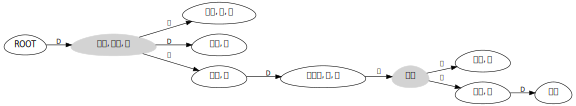

In [110]:
def merge_chunk(bnst):
    chunk="".join(mrph.midasi for mrph in bnst.mrph_list())
    tag_size=len(bnst.tag_list())
    return f"{chunk}({tag_size})"
def merge_tag(tag):
    chunk=", ".join(mrph.midasi for mrph in tag.mrph_list())
    return chunk

def print_predicates(result):
    deps={}
    predicates=[]
    for tag in result.tag_list():
        if tag.pas is not None:  # find predicate
            print(tag.tag_id, '. 述語: %s' % ''.join(mrph.midasi for mrph in tag.mrph_list()))
            predicates.append(merge_tag(tag))
            for case, args in tag.pas.arguments.items():  # case: str, args: list of Argument class
                for arg in args:  # arg: Argument class
                    print('\t格: %s,  項: %s  (項の基本句ID: %d)' % (case, arg.midasi, arg.tid))
                    put_items(deps, {tag.tag_id, arg.tid}, case)
    print(deps, predicates)
    return deps, predicates

class KnpViz(object):
    def __init__(self, shape='egg', size='8,5', fontsize=0):
        from graphviz import Digraph
        self.f = Digraph('deps', filename='deps.gv')
        self.f.attr(rankdir='LR', size=size)
        # font 'Calibri' support Arabic text
        self.f.attr('node', shape=shape, fontname='Calibri')
        if fontsize != 0:
            self.f.attr(fontsize=str(fontsize))
            
        self.prop_sets = {'VERB': lambda f: f.attr('node', style='filled', color='lightgrey'),
                     'PRON': lambda f: f.attr('node', style='dashed', color='red'),
                     'AUX': lambda f: f.attr('node', style='dashed', color='green'),
                     'NOUN': lambda f: f.attr('node', style='solid', color='blue'),
                     }
    
    def default_node(self):
        self.f.attr('node', style='solid', color='black')
        
    def process_tags(self, sents):
        result = knp.parse(sents)
        print(sents)
        deps, predicates=print_predicates(result)
        self.prop_sets['VERB'](self.f)
        for pr in predicates:
            self.f.node(pr)
        
        self.default_node()
        establish_set={}
        
        rs=[]
        words=result.tag_list()
        for tag in words: # 各基本句へのアクセス
            if verbose:
                print("\tID:%d, 見出し:%s, 係り受けタイプ:%s, 親基本句ID:%d, 素性:%s" \
                        % (tag.tag_id, "".join(mrph.midasi for mrph in tag.mrph_list()), tag.dpndtype, tag.parent_id, tag.fstring))
            node_text=merge_tag(tag)
            rs.append((tag.tag_id, "".join(mrph.midasi for mrph in tag.mrph_list()),
                       ",".join(pos_list(tag)),
                       ",".join(entity_list(tag)),
                       tag.dpndtype, tag.parent_id, tag.fstring))
            rel=tag.dpndtype
            if tag.parent_id==-1:
                head_node='ROOT'
            else:
                head_node=merge_tag(words[tag.parent_id])                
                rel=get_by_keyset(deps, {tag.tag_id, tag.parent_id})
                # print(tag.tag_id, tag.parent_id, {tag.tag_id, tag.parent_id}, rel)
                if rel is None:
                    rel=tag.dpndtype
                else:
                    remove_by_keyset(deps, {tag.tag_id, tag.parent_id})
            self.f.edge(head_node, node_text, label=rel, fontsize='11', fontname='Calibri')
        
        display(sagas.to_df(rs, ['ID', '見出し', 'POS', 'Entities',
                                 '係り受けタイプ(dep_type)', '親基本句ID', '素性']))
        print('leaves', deps)            
        return self.f
    
    def process(self, sents):
        result = knp.parse(sents)
        print(sents)
        print_predicates(result)
        
        rs=[]
        words=result.bnst_list()
        for bnst in words: # 各文節へのアクセス
            if verbose:
                print("\tID:%d, 見出し:%s, 係り受けタイプ:%s, 親文節ID:%d, 素性:%s" \
                        % (bnst.bnst_id, "".join(mrph.midasi for mrph in bnst.mrph_list()), bnst.dpndtype, bnst.parent_id, bnst.fstring))
            node_text=merge_chunk(bnst)
            rs.append((bnst.bnst_id, node_text, 
                       ",".join(pos_list(bnst)),
                       ",".join(entity_list(bnst)),
                       bnst.dpndtype, bnst.parent_id, bnst.fstring))
            if bnst.parent_id==-1:
                head_node='ROOT'
            else:
                head_node=merge_chunk(words[bnst.parent_id])
            self.f.edge(head_node, node_text, label=bnst.dpndtype, fontsize='11', fontname='Calibri')
        display(sagas.to_df(rs, ['ID', '見出し', 'POS', 'Entities', 
                                 '係り受けタイプ(dep_type)', '親文節ID', '素性']))    
        return self.f

# KnpViz().process('各文節へのアクセス')
# KnpViz().process("私は望遠鏡で泳いでいる少女を見た。")
# KnpViz().process_tags("私は望遠鏡で泳いでいる少女を見た。")
sent='久保氏は当初、連合を支持基盤とする民改連との連携を想定した。'
KnpViz().process_tags(sent)

私の趣味は、多くの小旅行をすることです。
5 . 述語: する
	格: ヲ,  項: 旅行  (項の基本句ID: 4)
	格: 外の関係,  項: こと  (項の基本句ID: 6)
6 . 述語: ことです。
	格: ガ,  項: 趣味  (項の基本句ID: 1)
{'4:5': 'ヲ', '5:6': '外の関係', '1:6': 'ガ'} ['する', 'こと, です, 。']


,ID,見出し,POS,Entities,係り受けタイプ(dep_type),親文節ID,素性
0,0,私の(1),"n,p",,D,1,<文頭><一人称><SM-主体><SM-人><助詞><連体修飾><体言><一文字漢字><係:...
1,1,趣味は、(1),"n,p,*",,D,5,<ハ><読点><助詞><体言><係:未格><提題><区切:3-5><主題表現><格要素><連...
2,2,多くの(1),"n,p",,D,3,<助詞><連体修飾><体言><係:ノ格><区切:0-4><正規化代表表記:多く/おおく><主...
3,3,小旅行を(2),"p,n,p",,D,4,<サ変><ヲ><助詞><体言><係:ヲ格><区切:0-0><隣係絶対><格要素><連用要素>...
4,4,する(1),v,,D,5,<連体修飾><用言:動><係:連格><レベル:B><区切:0-5><ID:（動詞連体形副名）...
5,5,ことです。(1),"n,c,*",,D,-1,<文末><形副名詞><外の関係><句点><体言><用言:判><レベル:C><区切:5-5><...


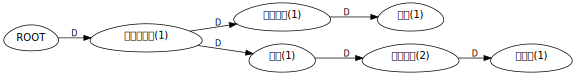

In [111]:
KnpViz().process('私の趣味は、多くの小旅行をすることです。')

私の趣味は、多くの小旅行をすることです。
5 . 述語: する
	格: ヲ,  項: 旅行  (項の基本句ID: 4)
	格: 外の関係,  項: こと  (項の基本句ID: 6)
6 . 述語: ことです。
	格: ガ,  項: 趣味  (項の基本句ID: 1)
{'4:5': 'ヲ', '5:6': '外の関係', '1:6': 'ガ'} ['する', 'こと, です, 。']


,ID,見出し,POS,Entities,係り受けタイプ(dep_type),親基本句ID,素性
0,0,私の,"n,p",,D,1,<文頭><一人称><SM-主体><SM-人><助詞><連体修飾><体言><一文字漢字><係:...
1,1,趣味は、,"n,p,*",,D,6,<ハ><読点><助詞><体言><係:未格><提題><区切:3-5><主題表現><格要素><連...
2,2,多くの,"n,p",,D,4,<助詞><連体修飾><体言><係:ノ格><区切:0-4><名詞項候補><先行詞候補><係チ:...
3,3,小,p,,D,4,<文節内><係:文節内><受けNONE><正規化代表表記:小/しょう>
4,4,旅行を,"n,p",,D,5,<ヲ><助詞><体言><係:ヲ格><区切:0-0><隣係絶対><格要素><連用要素><サ変>...
5,5,する,v,,D,6,<連体修飾><用言:動><係:連格><レベル:B><区切:0-5><ID:（動詞連体形副名）...
6,6,ことです。,"n,c,*",,D,-1,<文末><形副名詞><外の関係><句点><体言><用言:判><レベル:C><区切:5-5><...


leaves {}


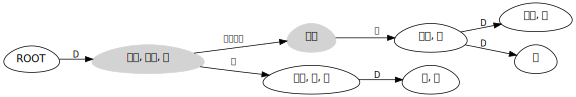

In [112]:
KnpViz().process_tags('私の趣味は、多くの小旅行をすることです。')

,ID,見出し,係り受けタイプ(dep_type),親文節ID,素性
0,0,下鴨神社の,D,1,<文頭><地名><助詞><連体修飾><体言><係:ノ格><区切:0-4><準主題表現><正規...
1,1,参道は,D,2,<ハ><助詞><体言><係:未格><提題><区切:3-5><主題表現><格要素><連用要素>...
2,2,暗かった。,D,-1,<文末><時制-過去><句点><用言:形><レベル:C><区切:5-5><ID:（文末）><...


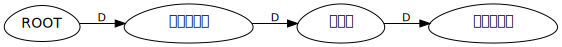

In [28]:
KnpViz().process('下鴨神社の参道は暗かった。')

下鴨神社の参道は暗かった。
3 . 述語: 暗かった。
	格: ガ,  項: 参道  (項の基本句ID: 2)
{'2:3': 'ガ'} ['暗かった, 。']


,ID,見出し,POS,Entities,係り受けタイプ(dep_type),親基本句ID,素性
0,0,下鴨,C,LOC,D,1,<文節内><係:文節内><文頭><地名><体言><名詞項候補><先行詞候補><SM-場所><...
1,1,神社の,"n,p",,D,2,<地名><助詞><連体修飾><体言><係:ノ格><区切:0-4><準主題表現><名詞項候補>...
2,2,参道は,"n,p",,D,3,<ハ><助詞><体言><係:未格><提題><区切:3-5><主題表現><格要素><連用要素>...
3,3,暗かった。,"j,*",,D,-1,<文末><時制-過去><句点><用言:形><レベル:C><区切:5-5><ID:（文末）><...


leaves {}


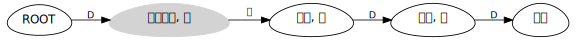

In [113]:
KnpViz().process_tags('下鴨神社の参道は暗かった。')

私は望遠鏡で泳いでいる少女を見た。
3 . 述語: 泳いでいる
	格: ガ,  項: 少女  (項の基本句ID: 4)
5 . 述語: 見た。
	格: ガ,  項: 私  (項の基本句ID: 0)
	格: ヲ,  項: 少女  (項の基本句ID: 4)
	格: デ,  項: 鏡  (項の基本句ID: 2)
{'3:4': 'ガ', '0:5': 'ガ', '4:5': 'ヲ', '2:5': 'デ'} ['泳いで, いる', '見た, 。']


,ID,見出し,POS,Entities,係り受けタイプ(dep_type),親基本句ID,素性
0,0,私は,"n,p",,D,5,<文頭><一人称><SM-主体><SM-人><ハ><助詞><体言><一文字漢字><係:未格>...
1,1,望遠,n,,D,2,<文節内><係:文節内><体言><名詞項候補><先行詞候補><正規化代表表記:望遠/ぼうえん>
2,2,鏡で,"n,p",,D,5,<デ><助詞><体言><係:デ格><区切:0-0><格要素><連用要素><一文字漢字><名詞...
3,3,泳いでいる,"v,s",,D,4,<連体修飾><用言:動><係:連格><レベル:B><区切:0-5><ID:（動詞連体）><連...
4,4,少女を,"n,p",,D,5,<SM-主体><SM-人><ヲ><助詞><体言><係:ヲ格><区切:0-0><格要素><連用...
5,5,見た。,"v,*",,D,-1,<文末><補文ト><時制-過去><句点><用言:動><レベル:C><区切:5-5><ID:（...


leaves {}


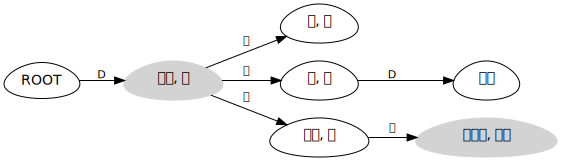

In [114]:
sent="私は望遠鏡で泳いでいる少女を見た。"
KnpViz().process_tags(sent)

久保氏は当初、連合を支持基盤とする民改連との連携を想定した。
5 . 述語: する
	格: ガ,  項: 民改連  (項の基本句ID: 6)
	格: ヲ,  項: 連合  (項の基本句ID: 2)
	格: ト,  項: 基盤  (項の基本句ID: 4)
8 . 述語: 想定した。
	格: ガ,  項: 久保  (項の基本句ID: 0)
	格: ヲ,  項: 連携  (項の基本句ID: 7)
{'5:6': 'ガ', '2:5': 'ヲ', '4:5': 'ト', '0:8': 'ガ', '7:8': 'ヲ'} ['する', '想定, した, 。']


,ID,見出し,POS,Entities,係り受けタイプ(dep_type),親基本句ID,素性
0,0,久保氏は,"J,s,p",PERSON,D,8,<文頭><人名><ハ><助詞><体言><係:未格><提題><区切:3-5><主題表現><格要...
1,1,当初、,"n,*",,D,8,<時間><強時間><読点><体言><係:無格従属:-1><並キ:名:&ST:4.0&&時間>...
2,2,連合を,"n,p",,D,5,<SM-主体><SM-組織><ヲ><助詞><体言><係:ヲ格><区切:0-0><格要素><連...
3,3,支持,n,,D,4,<文節内><係:文節内><サ変><体言><名詞項候補><先行詞候補><非用言格解析:動><照...
4,4,基盤と,"n,p",,D,5,<ト><助詞><体言><係:ト格><並キ:名:&ST:5.0><区切:1-4><並列タイプ:...
5,5,する,v,,D,6,<連体修飾><用言:動><係:連格><レベル:B><区切:0-5><ID:（動詞連体）><連...
6,6,民改連との,"n,p,p",,D,7,<ト><助詞><連体修飾><体言><係:連体><区切:0-4><名詞項候補><先行詞候補><...
7,7,連携を,"n,p",,D,8,<ヲ><助詞><体言><係:ヲ格><区切:0-0><格要素><連用要素><サ変><名詞項候補...
8,8,想定した。,"n,v,*",,D,-1,<文末><補文ト><サ変動詞><時制-過去><句点><用言:動><レベル:C><区切:5-5...


leaves {}


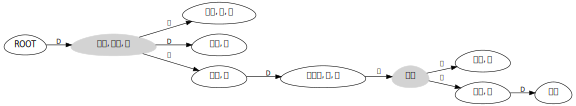

In [115]:
sent='久保氏は当初、連合を支持基盤とする民改連との連携を想定した。'
KnpViz().process_tags(sent)